In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os

from src.proj_utils import(
    tokenize_text,
    create_training_examples,
    prepare_datasets,
    build_vocabulary
)

from src.model import LSTMLangModel, train_model
from src.dataset import TextGenerationDataset, create_dataloaders
from src.evaluate_transformers import evaluate_distilgpt2_rouge, evaluate_text_generation

In [2]:
df = pd.read_csv('data/training.1600000.processed.noemoticon_reduced.csv', encoding='latin-1', header=None)
df.columns = ['sentiment', 'id', 'date', 'flag', 'user', 'text']

Блок приведения к нижнему регистру, удаления ссылок, упоминаний через @, спецсимоволов.
После - удалить лишние символы

In [3]:
df['text'] = df['text'].str.lower()
df['text'] = df['text'].str.replace(r'http\S+|www\S+|@\w+|[^\w\s]', '', regex=True)
df['text'] = df['text'].str.strip()

Получение токенов из текста публикаций и обучающих примеров

In [4]:
df['tokenized'] = df['text'].apply(tokenize_text)

In [5]:
X, Y = create_training_examples(df['tokenized'].to_list())

Используется 28 процессов для создания примеров...


Разделение на обучающую проверочную и тестовую выборки

In [6]:
X_train, X_val, X_test, y_train, y_val, y_test = prepare_datasets(X, Y)

In [7]:
print(f"Размеры данных:")
print(f"Train: {len(X_train)} примеров")
print(f"Validation: {len(X_val)} примеров")
print(f"Test: {len(X_test)} примеров")

Размеры данных:
Train: 96686 примеров
Validation: 12086 примеров
Test: 12086 примеров


Создать словарь

In [8]:
all_tokens = []
for seq in X:
    all_tokens.extend(seq)
all_tokens.extend(Y)
vocab = build_vocabulary([all_tokens], min_freq=1)
vocab_size = len(vocab)

print(f"Размер словаря: {vocab_size}")
print(f"Примеры слов в словаре: {list(vocab.keys())[:20]}")


test_words = ["this", "is", "a"]
for word in test_words:
    if word in vocab:
        print(f"'{word}' есть в словаре: индекс {vocab[word]}")
    else:
        print(f"'{word}' НЕТ в словаре!")

Размер словаря: 14307
Примеры слов в словаре: ['<PAD>', '<UNK>', 'a', 'thats', 'bummer', 'you', 'shoulda', 'got', 'david', 'carr', 'of', 'third', 'day', 'to', 'do', 'it', 'is', 'upset', 'that', 'he']
'this' есть в словаре: индекс 159
'is' есть в словаре: индекс 16
'a' есть в словаре: индекс 2


Создать загрузчиков данных

In [9]:
batch_size = 64
max_seq_length = 50

train_loader, val_loader, test_loader = create_dataloaders(
        X_train, y_train, X_val, y_val, X_test, y_test,
        vocab, batch_size, max_seq_length
    )

Создать модель

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используемое устройство: {device}")

model = LSTMLangModel(
    vocab_size=vocab_size,
    embedding_dim=256,
    hidden_dim=512,
    num_layers=2,
    dropout=0.3
).to(device)
print(f"Количество параметров модели: {sum(p.numel() for p in model.parameters()):,}")

Используемое устройство: cuda
Количество параметров модели: 14,680,291


Обучение модели

In [11]:
train_losses, val_losses, val_rouge_scores = train_model(
        model, train_loader, val_loader, vocab_size, device,
        num_epochs=10, learning_rate=0.001
    )

Эпохи обучения:  10%|█         | 1/10 [00:28<04:13, 28.14s/эпоха, train_loss=7.1114, val_loss=7.0152, rouge1=0.0476, lr=0.001000]

ROUGE Scores: {'rouge1': np.float64(0.047619047619047616), 'rouge2': np.float64(0.0), 'rougeL': np.float64(0.047619047619047616), 'rougeLsum': np.float64(0.047619047619047616)}
Эпоха 1/10, Train Loss: 7.1114, Val Loss: 7.0152, ROUGE-1: 0.0476, ROUGE-2: 0.0000, ROUGE-L: 0.0476, LR: 0.001000


Эпохи обучения:  20%|██        | 2/10 [00:56<03:45, 28.25s/эпоха, train_loss=6.9858, val_loss=7.0774, rouge1=0.0476, lr=0.001000]

ROUGE Scores: {'rouge1': np.float64(0.047619047619047616), 'rouge2': np.float64(0.0), 'rougeL': np.float64(0.047619047619047616), 'rougeLsum': np.float64(0.047619047619047616)}
Эпоха 2/10, Train Loss: 6.9858, Val Loss: 7.0774, ROUGE-1: 0.0476, ROUGE-2: 0.0000, ROUGE-L: 0.0476, LR: 0.001000


Эпохи обучения:  30%|███       | 3/10 [01:24<03:18, 28.30s/эпоха, train_loss=6.9423, val_loss=7.1422, rouge1=0.0370, lr=0.001000]

ROUGE Scores: {'rouge1': np.float64(0.037037037037037035), 'rouge2': np.float64(0.0), 'rougeL': np.float64(0.037037037037037035), 'rougeLsum': np.float64(0.037037037037037035)}
Эпоха 3/10, Train Loss: 6.9423, Val Loss: 7.1422, ROUGE-1: 0.0370, ROUGE-2: 0.0000, ROUGE-L: 0.0370, LR: 0.001000


Эпохи обучения:  40%|████      | 4/10 [01:53<02:49, 28.31s/эпоха, train_loss=6.9280, val_loss=7.1883, rouge1=0.0370, lr=0.000500]

ROUGE Scores: {'rouge1': np.float64(0.037037037037037035), 'rouge2': np.float64(0.0), 'rougeL': np.float64(0.037037037037037035), 'rougeLsum': np.float64(0.037037037037037035)}
Эпоха 4/10, Train Loss: 6.9280, Val Loss: 7.1883, ROUGE-1: 0.0370, ROUGE-2: 0.0000, ROUGE-L: 0.0370, LR: 0.000500


Эпохи обучения:  50%|█████     | 5/10 [02:21<02:21, 28.32s/эпоха, train_loss=6.9087, val_loss=7.2214, rouge1=0.0370, lr=0.000500]

ROUGE Scores: {'rouge1': np.float64(0.037037037037037035), 'rouge2': np.float64(0.0), 'rougeL': np.float64(0.037037037037037035), 'rougeLsum': np.float64(0.037037037037037035)}
Эпоха 5/10, Train Loss: 6.9087, Val Loss: 7.2214, ROUGE-1: 0.0370, ROUGE-2: 0.0000, ROUGE-L: 0.0370, LR: 0.000500


Эпохи обучения:  60%|██████    | 6/10 [02:49<01:53, 28.35s/эпоха, train_loss=6.9054, val_loss=7.2555, rouge1=0.0370, lr=0.000500]

ROUGE Scores: {'rouge1': np.float64(0.037037037037037035), 'rouge2': np.float64(0.0), 'rougeL': np.float64(0.037037037037037035), 'rougeLsum': np.float64(0.037037037037037035)}
Эпоха 6/10, Train Loss: 6.9054, Val Loss: 7.2555, ROUGE-1: 0.0370, ROUGE-2: 0.0000, ROUGE-L: 0.0370, LR: 0.000500


Эпохи обучения:  70%|███████   | 7/10 [03:18<01:25, 28.34s/эпоха, train_loss=6.9028, val_loss=7.3226, rouge1=0.0476, lr=0.000250]

ROUGE Scores: {'rouge1': np.float64(0.047619047619047616), 'rouge2': np.float64(0.0), 'rougeL': np.float64(0.047619047619047616), 'rougeLsum': np.float64(0.047619047619047616)}
Эпоха 7/10, Train Loss: 6.9028, Val Loss: 7.3226, ROUGE-1: 0.0476, ROUGE-2: 0.0000, ROUGE-L: 0.0476, LR: 0.000250


Эпохи обучения:  80%|████████  | 8/10 [03:46<00:56, 28.33s/эпоха, train_loss=6.8924, val_loss=7.3218, rouge1=0.0370, lr=0.000250]

ROUGE Scores: {'rouge1': np.float64(0.037037037037037035), 'rouge2': np.float64(0.0), 'rougeL': np.float64(0.037037037037037035), 'rougeLsum': np.float64(0.037037037037037035)}
Эпоха 8/10, Train Loss: 6.8924, Val Loss: 7.3218, ROUGE-1: 0.0370, ROUGE-2: 0.0000, ROUGE-L: 0.0370, LR: 0.000250


Эпохи обучения:  90%|█████████ | 9/10 [04:14<00:28, 28.25s/эпоха, train_loss=6.8890, val_loss=7.3471, rouge1=0.0476, lr=0.000250]

ROUGE Scores: {'rouge1': np.float64(0.047619047619047616), 'rouge2': np.float64(0.0), 'rougeL': np.float64(0.047619047619047616), 'rougeLsum': np.float64(0.047619047619047616)}
Эпоха 9/10, Train Loss: 6.8890, Val Loss: 7.3471, ROUGE-1: 0.0476, ROUGE-2: 0.0000, ROUGE-L: 0.0476, LR: 0.000250


Эпохи обучения: 100%|██████████| 10/10 [04:42<00:00, 28.25s/эпоха, train_loss=6.8854, val_loss=7.3843, rouge1=0.0370, lr=0.000125]

ROUGE Scores: {'rouge1': np.float64(0.037037037037037035), 'rouge2': np.float64(0.0), 'rougeL': np.float64(0.037037037037037035), 'rougeLsum': np.float64(0.037037037037037035)}
Эпоха 10/10, Train Loss: 6.8854, Val Loss: 7.3843, ROUGE-1: 0.0370, ROUGE-2: 0.0000, ROUGE-L: 0.0370, LR: 0.000125


Визуализация результатов

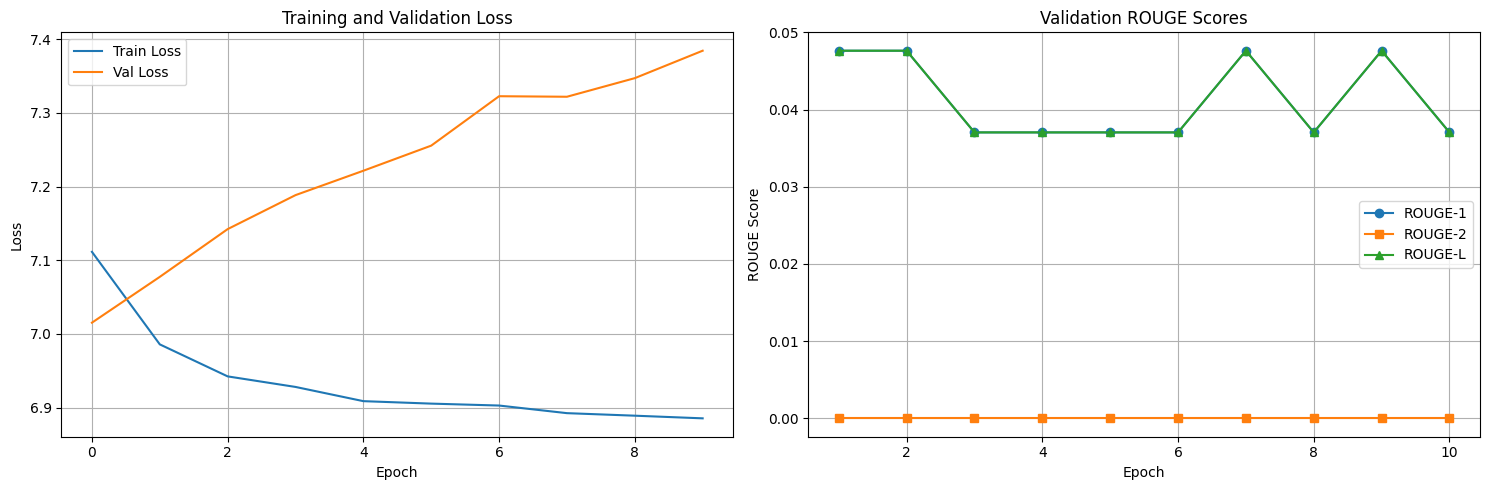


Финальные метрики:
Final Train Loss: 6.8854
Final Val Loss: 7.3843
Final ROUGE-1: 0.0370
Final ROUGE-2: 0.0000
Final ROUGE-L: 0.0370


In [12]:
plt.figure(figsize=(15,5))

#Потери
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

#Rouge метрики
plt.subplot(1, 2, 2)
rouge1_scores = [score.get('rouge1', 0) for score in val_rouge_scores if score]
rouge2_scores = [score.get('rouge2', 0) for score in val_rouge_scores if score]
rougeL_scores = [score.get('rougeL', 0) for score in val_rouge_scores if score]

epochs = range(1, len(rouge1_scores) + 1)
plt.plot(epochs, rouge1_scores, label='ROUGE-1', marker='o')
plt.plot(epochs, rouge2_scores, label='ROUGE-2', marker='s')
plt.plot(epochs, rougeL_scores, label='ROUGE-L', marker='^')
plt.xlabel('Epoch')
plt.ylabel('ROUGE Score')
plt.title('Validation ROUGE Scores')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_metrics.png')
plt.show()

print("\nФинальные метрики:")
print(f"Final Train Loss: {train_losses[-1]:.4f}")
print(f"Final Val Loss: {val_losses[-1]:.4f}")
if val_rouge_scores and val_rouge_scores[-1]:
    print(f"Final ROUGE-1: {val_rouge_scores[-1]['rouge1']:.4f}")
    print(f"Final ROUGE-2: {val_rouge_scores[-1]['rouge2']:.4f}")
    print(f"Final ROUGE-L: {val_rouge_scores[-1]['rougeL']:.4f}")

Тестирование модели

In [13]:
model.eval()
test_loss = 0
criterion = nn.CrossEntropyLoss(ignore_index=0)

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        targets = batch['target'].to(device)
        
        outputs, _ = model(input_ids)
        loss = criterion(outputs, targets)
        
        test_loss += loss.item()

avg_test_loss = test_loss / len(test_loader)
print(f"Значение потери на этапе тестирования: {avg_test_loss:.4f}")

Значение потери на этапе тестирования: 7.4267


Генерация связности

In [14]:
test_cases = [
    (["i", "feel", "so"], "happy today because the sun is shining"),
    (["the", "movie", "was"], "really amazing with great special effects"),
    (["machine", "learning", "is"], "a fascinating field that continues to evolve"),
    (["the", "cat", "is"], "on the map")
]
evaluate_text_generation(model, test_cases, vocab, device)


ОЦЕНКА КАЧЕСТВА ГЕНЕРАЦИИ


Начальный контекст: i feel so
ГЕНЕРАЦИЯ ТЕКСТА:

Тест 1:
Контекст:    i feel so
Ожидалось:   happy today because the sun is shining
Сгенерировано: i i i i the to a i to i to to i my i to i the to to i a i to to i to to to i
Схожесть:    0.14

Начальный контекст: the movie was
ГЕНЕРАЦИЯ ТЕКСТА:

Тест 2:
Контекст:    the movie was
Ожидалось:   really amazing with great special effects
Сгенерировано: the a the i the i to my a a i to the the i i i i i my the i the i to i to to to a
Схожесть:    0.00

Начальный контекст: machine learning is
ГЕНЕРАЦИЯ ТЕКСТА:

Тест 3:
Контекст:    machine learning is
Ожидалось:   a fascinating field that continues to evolve
Сгенерировано: my i i to the the the to to to the i the a i to my a to to to the the a a i i a to a
Схожесть:    0.29

Начальный контекст: the cat is
ГЕНЕРАЦИЯ ТЕКСТА:

Тест 4:
Контекст:    the cat is
Ожидалось:   on the map
Сгенерировано: to i i the the i i i i my my i a to to to i i the i to a my my to the t

Оценка с использованием distilgpt2

In [15]:
val_texts = []
for i, (x_seq, y_token) in enumerate(zip(X_val, y_val)):
    if i < 100:  # Ограничение количества для скорости
        text = ' '.join(x_seq) + ' ' + y_token
        val_texts.append(text)

gpt2_results = evaluate_distilgpt2_rouge(val_texts[:50])
print("\nСравнение моделей:")
print(f"LSTM ROUGE-1: {val_rouge_scores[-1]['rouge1']:.4f}")
print(f"DistilGPT2 ROUGE-1: {gpt2_results['rouge1']:.4f}")


Загрузка модели DistilGPT2...


Device set to use cuda:0


Начинаем оценку модели...


Оценка текстов:   0%|          | 0/50 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Both `max_new_tokens` (=256) and `max_length`(=31) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Оценка текстов:  42%|████▏     | 21/50 [00:04<00:05,  5.29it/s]Both `max_new_tokens` (=256) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_ne


РЕЗУЛЬТАТЫ ОЦЕНКИ DistilGPT2
ROUGE-1: 0.0255
ROUGE-2: 0.0000
ROUGE-L: 0.0165
Оценено текстов: 20

Примеры предсказаний:

Пример 1:
Контекст: ['lol', 'yea', 'i', 'really', 'hated', 'that', 'episode', 'last', 'night', 'and', 'i', 'hated', 'the', 'fake', 'obit']...
Ожидалось: online even more im gonna miss
Предсказано: uary.



I've been in the car for the last week and i have been in the car for the last week and i have been in the car for the last week and i have been in the car for the last week and i have been in the car for the last week and i have been in the car for the last week and i have been in the car for the last week and i have been in the car for the last week and i have been in the car for the last week and i have been in the car for the last week and i have been in the car for the last week and i have been in the car for the last week and i have been in the car for the last week and i have been in the car for the last week and i have been in the car for the last week and

Сохранение модели

In [16]:
save_path = "models/lstm_language_model.pth"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
torch.save({
        'model_state_dict': model.state_dict(),
        'vocab': vocab,
        'model_config': {
            'vocab_size': vocab_size,
            'embedding_dim': 256,
            'hidden_dim': 512,
            'num_layers': 2,
            'dropout': 0.3
        }
    }, save_path)
print(f"Модель сохранена в: {save_path}")

Модель сохранена в: models/lstm_language_model.pth


# Вывод

Исходя из наблюдающегося чрезмерно большого времени на обучение нейросети было принято решение урезать с 1,6М записей до 10К записей в исходном .csv файле, подаваемого на вход. Даже при таком кардинальном уменьшении обучающей выборки результат на основе LSTM превосходит DistilGPT2:

LSTM ROUGE-1: <b>0.0370</b><br>
DistilGPT2 ROUGE-1: <b>0.0023</b>
